In [ ]:
import kagglehub
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("galaxyh/kdd-cup-1999-data")

print("Path to dataset files:", path)

100%|██████████| 87.8M/87.8M [00:00<00:00, 119MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/galaxyh/kdd-cup-1999-data/versions/1


In [ ]:
#  3) Load the 10% corrected file
df = pd.read_csv(path + "/kddcup.data_10_percent_corrected", header=None)

In [ ]:
import pandas as pd

# Load the CSV
df = pd.read_csv(path + "/kddcup.data_10_percent_corrected", header=None)

# Add column names (same as before)
columns = [
    'duration','protocol_type','service','flag','src_bytes','dst_bytes','land',
    'wrong_fragment','urgent','hot','num_failed_logins','logged_in',
    'num_compromised','root_shell','su_attempted','num_root','num_file_creations',
    'num_shells','num_access_files','num_outbound_cmds','is_host_login',
    'is_guest_login','count','srv_count','serror_rate','srv_serror_rate',
    'rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate',
    'srv_diff_host_rate','dst_host_count','dst_host_srv_count',
    'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate',
    'dst_host_rerror_rate','dst_host_srv_rerror_rate','label'
]
df.columns = columns

print(" First few rows:")
display(df.head())


 First few rows:


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [ ]:
#  4) Preprocess: Encode categorical columns
le = LabelEncoder()
df['protocol_type'] = le.fit_transform(df['protocol_type'])
df['service'] = le.fit_transform(df['service'])
df['flag'] = le.fit_transform(df['flag'])

# Prepare features (drop label)
X = df.drop(['label'], axis=1)

# Scale numeric data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
#  5) Train Isolation Forest
iso_model = IsolationForest(n_estimators=100, contamination=0.2, random_state=42)
iso_model.fit(X_scaled)

# Predict anomalies (-1 = anomaly, 1 = normal)
df['anomaly'] = iso_model.predict(X_scaled)

print("\n Anomaly counts (-1 = anomaly, 1 = normal):")
print(df['anomaly'].value_counts())

# True labels for comparison
df['true_label'] = df['label'].apply(lambda x: 'normal' if x == 'normal.' else 'attack')

print("\n Crosstab: Predicted anomaly vs true label")
print(pd.crosstab(df['anomaly'], df['true_label']))


 Anomaly counts (-1 = anomaly, 1 = normal):
anomaly
 1    395219
-1     98802
Name: count, dtype: int64

 Crosstab: Predicted anomaly vs true label
true_label  attack  normal
anomaly                   
-1           57087   41715
 1          339656   55563


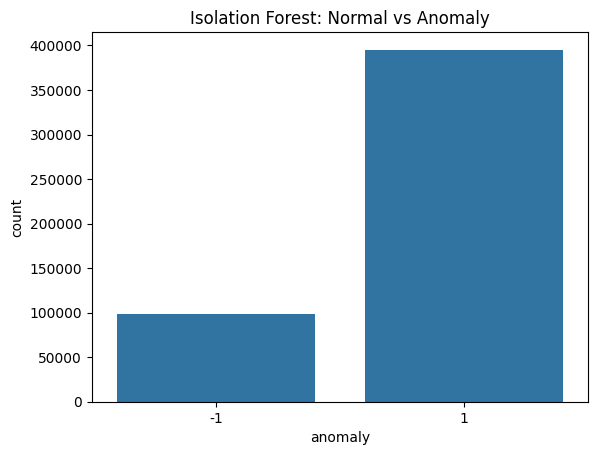

In [ ]:
# 6) Visualize results
sns.countplot(x='anomaly', data=df)
plt.title('Isolation Forest: Normal vs Anomaly')
plt.show()

In [ ]:
# 7) Save output with anomalies
df.to_csv('kddcup_with_anomalies.csv', index=False)
print("\n Results saved to: kddcup_with_anomalies.csv")


 Results saved to: kddcup_with_anomalies.csv


In [ ]:
# 8) Autoencoder for anomaly detection

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

In [ ]:
# Build Autoencoder model
input_dim = X_scaled.shape[1]

input_layer = Input(shape=(input_dim,))
encoder = Dense(32, activation="relu")(input_layer)
encoder = Dense(16, activation="relu")(encoder)
encoder = Dense(8, activation="relu")(encoder)

decoder = Dense(16, activation='relu')(encoder)
decoder = Dense(32, activation='relu')(decoder)
decoder = Dense(input_dim, activation='linear')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 41)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 41)             │         1,353 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,049 (15.82 KB)

 Trainable params: 4,049 (15.82 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train Autoencoder
history = autoencoder.fit(
    X_scaled, X_scaled,
    epochs=10,
    batch_size=256,
    shuffle=True,
    validation_split=0.1,
    verbose=1
)

Epoch 1/10
1737/1737 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.3898 - val_loss: 0.5031
Epoch 2/10
1737/1737 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.1842 - val_loss: 0.4586
Epoch 3/10
1737/1737 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1764 - val_loss: 0.3784
Epoch 4/10
1737/1737 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2384 - val_loss: 0.3669
Epoch 5/10
1737/1737 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.1528 - val_loss: 0.3493
Epoch 6/10
1737/1737 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.1154 - val_loss: 0.2847
Epoch 7/10
1737/1737 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0977 - val_loss: 0.3132
Epoch 8/10
1737/1737 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0855 - val_loss: 0.2849
Epoch 9/10
1737/1737 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0984 - val_loss: 0.2665
Epoch 10/10
1737/1737 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.1193 - val_loss: 0.3030


In [ ]:
# Predict reconstruction
X_pred = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - X_pred, 2), axis=1)

15439/15439 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step


In [ ]:
# Use top 5% MSE as threshold for anomaly
threshold = np.percentile(mse, 95)
print(f"Autoencoder MSE threshold: {threshold}")

df['ae_mse'] = mse
df['ae_anomaly'] = [1 if e > threshold else 0 for e in mse]  # 1 = anomaly

Autoencoder MSE threshold: 0.4697171524879116



Autoencoder Crosstab:
true_label  attack  normal
ae_anomaly                
0           375038   94296
1            21705    2982


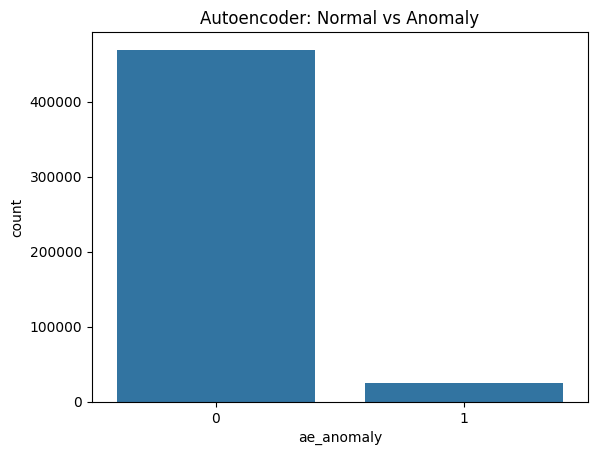

In [ ]:
# Compare to true labels
print("\nAutoencoder Crosstab:")
print(pd.crosstab(df['ae_anomaly'], df['true_label']))

#  Plot Autoencoder results
sns.countplot(x='ae_anomaly', data=df)
plt.title('Autoencoder: Normal vs Anomaly')
plt.show()

In [ ]:
# Save final results with both methods
df.to_csv('kddcup_with_iso_and_autoencoder.csv', index=False)
print(" Final results saved to: kddcup_with_iso_and_autoencoder.csv")


 Final results saved to: kddcup_with_iso_and_autoencoder.csv


In [ ]:

# Load the saved file
df_result = pd.read_csv('kddcup_with_iso_and_autoencoder.csv')

# Look at first few rows
df_result.head()


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,anomaly,true_label,ae_mse,ae_anomaly
0,0,1,22,9,181,5450,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,normal.,-1,normal,0.094371,0
1,0,1,22,9,239,486,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,normal.,1,normal,0.086496,0
2,0,1,22,9,235,1337,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,normal.,1,normal,0.078958,0
3,0,1,22,9,219,1337,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,normal.,1,normal,0.071818,0
4,0,1,22,9,217,2032,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,normal.,1,normal,0.065339,0


In [ ]:
# Add Binary True Label
df_result['true_attack'] = df_result['label'].apply(lambda x: 0 if x == 'normal.' else 1)


In [ ]:
# Map Predictions to Binary
# Use the correct column name: 'anomaly'
df_result['iso_attack'] = df_result['anomaly'].apply(lambda x: 0 if x == 1 else 1)

# 'ae_anomaly' is already correct
df_result['ae_attack'] = df_result['ae_anomaly']


In [ ]:
print(df_result.columns)

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'label', 'anomaly', 'true_label', 'ae_mse',
       'ae_anomaly', 'true_attack', 'iso_attack', 'ae_attack'],
      dtype='object')


In [ ]:
print(" Isolation Forest Crosstab:")
print(pd.crosstab(df_result['iso_attack'], df_result['true_attack'],
                  rownames=['Predicted'], colnames=['Actual']))

print("\n Autoencoder Crosstab:")
print(pd.crosstab(df_result['ae_attack'], df_result['true_attack'],
                  rownames=['Predicted'], colnames=['Actual']))


 Isolation Forest Crosstab:
Actual         0       1
Predicted               
0          55563  339656
1          41715   57087

 Autoencoder Crosstab:
Actual         0       1
Predicted               
0          94296  375038
1           2982   21705


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

print(" Isolation Forest Performance:")
print(confusion_matrix(df_result['true_attack'], df_result['iso_attack']))
print(classification_report(df_result['true_attack'], df_result['iso_attack']))

print("\n Autoencoder Performance:")
print(confusion_matrix(df_result['true_attack'], df_result['ae_attack']))
print(classification_report(df_result['true_attack'], df_result['ae_attack']))


 Isolation Forest Performance:
[[ 55563  41715]
 [339656  57087]]
              precision    recall  f1-score   support

           0       0.14      0.57      0.23     97278
           1       0.58      0.14      0.23    396743

    accuracy                           0.23    494021
   macro avg       0.36      0.36      0.23    494021
weighted avg       0.49      0.23      0.23    494021


 Autoencoder Performance:
[[ 94296   2982]
 [375038  21705]]
              precision    recall  f1-score   support

           0       0.20      0.97      0.33     97278
           1       0.88      0.05      0.10    396743

    accuracy                           0.23    494021
   macro avg       0.54      0.51      0.22    494021
weighted avg       0.75      0.23      0.15    494021



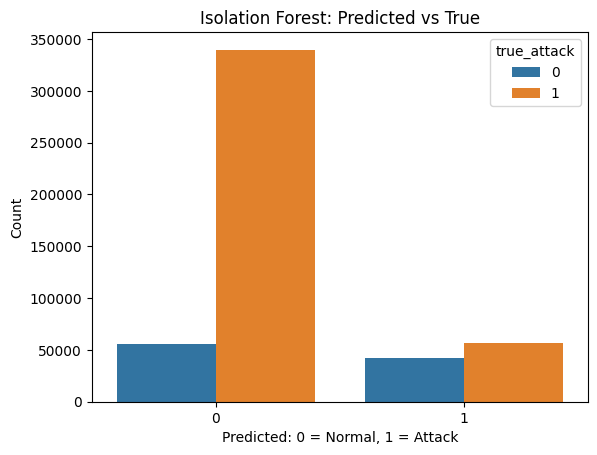

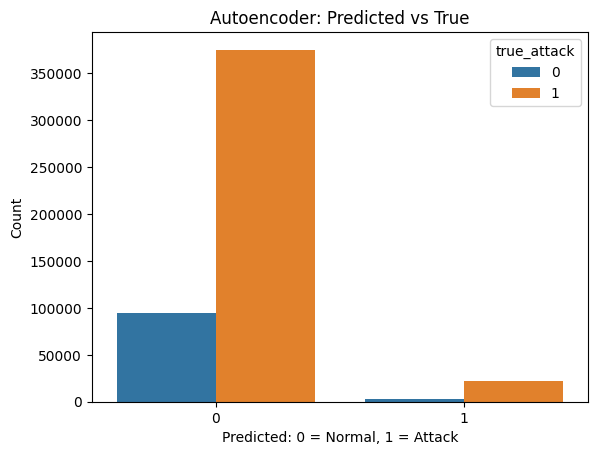

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Isolation Forest plot
sns.countplot(x='iso_attack', hue='true_attack', data=df_result)
plt.title("Isolation Forest: Predicted vs True")
plt.xlabel("Predicted: 0 = Normal, 1 = Attack")
plt.ylabel("Count")
plt.show()

# Autoencoder plot
sns.countplot(x='ae_attack', hue='true_attack', data=df_result)
plt.title("Autoencoder: Predicted vs True")
plt.xlabel("Predicted: 0 = Normal, 1 = Attack")
plt.ylabel("Count")
plt.show()


In [ ]:
df_result.to_csv('kddcup_with_all_results_final.csv', index=False)
print(" Final results saved to: kddcup_with_all_results_final.csv")


 Final results saved to: kddcup_with_all_results_final.csv
